In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import shap
import sklearn
import numpy as np

# Define a more realistic dataset for credit score prediction
# Features: Payment history (%), Credit utilization (%), Credit history length (years), Types of credit, New credit inquiries
# Labels: Ground truth credit scores (synthetic for demonstration purposes)
data = [
    [95, 30, 10, 3, 2, 750],
    [85, 45, 8, 2, 5, 700],
    [65, 70, 5, 1, 10, 600],
    [90, 40, 15, 4, 3, 720],
    [80, 50, 7, 2, 7, 680],
    [99, 20, 20, 5, 1, 800],
    [70, 60, 4, 1, 9, 640],
    [88, 35, 12, 3, 2, 730],
    [55, 85, 3, 1, 12, 580],
    [92, 25, 18, 4, 4, 760]
]

# Split features and labels
features = np.array([d[:-1] for d in data], dtype=np.float32)
labels = np.array([d[-1] for d in data], dtype=np.float32).reshape(-1, 1)

# Convert to PyTorch tensors
X = torch.tensor(features)
y = torch.tensor(labels)

# Define a simpler linear regression model without a hidden layer
class SimpleCreditScoreModel(nn.Module):
    def __init__(self):
        super(SimpleCreditScoreModel, self).__init__()
        self.linear = nn.Linear(5, 1)  # Direct mapping from 5 features to 1 output

    def forward(self, x):
        return self.linear(x)

# Initialize the linear model, loss function, and optimizer
model = SimpleCreditScoreModel()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001)

# Training loop for the simpler linear model
epochs = 2000
for epoch in range(epochs):
    # Forward pass
    outputs = model(X)
    loss = criterion(outputs, y)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss occasionally
    if (epoch + 1) % 200 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Get the weights and biases of the linear layer to estimate feature importance
weights = model.linear.weight.data
bias = model.linear.bias.data

# Feature names for clarity
feature_names = [
    "Payment History", 
    "Credit Utilization", 
    "Credit History Length", 
    "Types of Credit", 
    "New Credit Inquiries"
]

# Print the equation for interpretability
print("\nEquation for Feature Influence on Credit Score:")

# Construct the equation string for a linear relationship
equation_terms = []
for i, (weight, feature_name) in enumerate(zip(weights[0], feature_names)):
    equation_terms.append(f"({weight.item():.4f}) * {feature_name}")

equation = " + ".join(equation_terms) + f" + Bias({bias.item():.4f})"
print("Credit Score Estimate = " + equation)

# Compute percentage contribution of each feature
absolute_weights = torch.abs(weights[0])  # Take absolute values to consider magnitude only
total_weight = torch.sum(absolute_weights)
percent_contributions = (absolute_weights / total_weight) * 100  # Calculate percentage contributions

# Print the percentage contribution of each feature
print("\nPercentage Contribution of Each Feature to the Credit Score Estimate:")
for i, (feature_name, contribution) in enumerate(zip(feature_names, percent_contributions)):
    print(f"{feature_name}: {contribution.item():.2f}%")


Epoch [200/2000], Loss: 226.9816
Epoch [400/2000], Loss: 215.6056
Epoch [600/2000], Loss: 208.2923
Epoch [800/2000], Loss: 203.2630
Epoch [1000/2000], Loss: 199.5530
Epoch [1200/2000], Loss: 196.6356
Epoch [1400/2000], Loss: 194.2216
Epoch [1600/2000], Loss: 192.1468
Epoch [1800/2000], Loss: 190.3196
Epoch [2000/2000], Loss: 188.6838

Equation for Feature Influence on Credit Score:
Credit Score Estimate = (7.0068) * Payment History + (1.6562) * Credit Utilization + (2.8707) * Credit History Length + (0.5340) * Types of Credit + (2.7402) * New Credit Inquiries + Bias(0.0088)

Percentage Contribution of Each Feature to the Credit Score Estimate:
Payment History: 47.32%
Credit Utilization: 11.18%
Credit History Length: 19.39%
Types of Credit: 3.61%
New Credit Inquiries: 18.50%


SHAP values for the first instance: .values =
array([-3.97955274,  5.07876808, -0.0799609 , -0.08179431,  1.19387589])

.base_values =
array([-38.17191677])

.data =
array([95., 30., 10.,  3.,  2.], dtype=float32)
Feature values for the first instance: [95. 30. 10.  3.  2.]
Expected value: -38.17191677093506


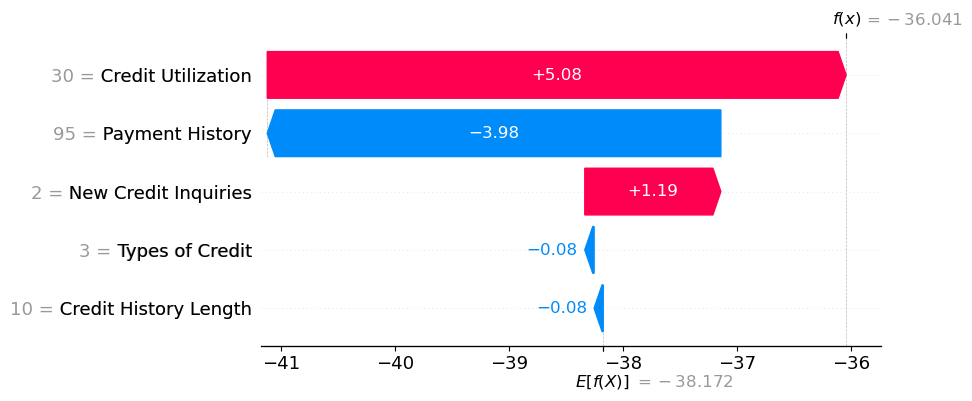

In [55]:
# Define a prediction function for your PyTorch model
def model_predict(data):
    data_tensor = torch.tensor(data, dtype=torch.float32)  # Convert input data to tensor
    return model(data_tensor).detach().numpy()  # Get predictions as NumPy array

# Create a SHAP explainer using Explainer
explainer = shap.Explainer(model_predict, X.numpy())  # Use the input features for background data

# Calculate SHAP values for the dataset
shap_values = explainer(X.numpy())  # Calculate SHAP values

# Select the first instance's SHAP values
instance_index = 0  # Change this index to analyze a different instance
first_instance_shap_values = shap_values[instance_index]  # Get SHAP values for the specified instance
first_instance_features = X.numpy()[instance_index]       # Get features for the specified instance

# Print to debug
print("SHAP values for the first instance:", first_instance_shap_values)  # Debugging output
print("Feature values for the first instance:", first_instance_features)   # Debugging output
print("Expected value:", expected_value)  # Debugging output


# Create the Explanation object for the waterfall plot
explanation = shap.Explanation(
    values=first_instance_shap_values,
    base_values=expected_value,
    data=first_instance_features,
    feature_names=feature_names
)

# Create the waterfall plot for the first instance
shap.waterfall_plot(explanation)  # Pass the Explanation object to the waterfall plot